# BioNeMo - Geneformer inferencing for single cell downstream tasks

This tutorial showcases how to run the BioNeMo container, pre-train a geneformer model, and use it for inferencing downstream single cell tasks. At the end of this tutorial, a user will learn:
- launching the BioNeMo container
- Download data from czi to use for pre-training and inference.
- Convert AnnData files into the sparse SCDL memmap format used by BioNeMo
- Kick-off pretraining with a custom single cell dataset
- Restore the pre-trained model and perform inference with the same czi dataset.


### Prerequisites:
- BioNeMo Framework container is running (refer to the [Getting Started](../index.md) section)


#### Running the BioNeMo container

This example has been built by launching the container in a local machine with 2 x A6000 RTX GPUs. Refer to specific instructions for [remote and multi-node launch]

Once the container is launched, navigate to http://0.0.0.0:8888, http://localhost:8888, or the IP address of the workstation/node. A JupyterLab instance should show up.

#### Copy this code and input files into JupyterLab

In the launched JupyterLab, run the codes in a Jupyter notebook as provided in the code cells below.

## Getting example single cell data and setting it up for inference

First, we must acquire single cell training data for inference. To do this we will install the cellxgene-census api and download a small dataset. We use the example provided by the czi api examples page to download a single h5ad file. Generally, our workflow expects a collection of h5ad files to be used for pre-training. In this case, we restrict to 100k cells from a single dataset  to keep training time and downloading time small.

In [2]:
# Below are paths required for setting up pre-training and inference.
from bionemo.core import BIONEMO_CACHE_DIR


single_cell_workdir = BIONEMO_CACHE_DIR / "singlecell_tutorial"

tutorial_data_dir = single_cell_workdir / "download_anndata"
train_tutorial_data_dir = single_cell_workdir / "download_anndata/train"
val_tutorial_data_dir = single_cell_workdir / "download_anndata/val"
test_tutorial_data_dir = single_cell_workdir / "download_anndata/test"

train_tutorial_processed_dir = single_cell_workdir / "processed_data/train"
val_tutorial_processed_dir = single_cell_workdir / "processed_data/val"
test_tutorial_processed_dir = single_cell_workdir / "processed_data/test"
tutorial_output_dir = single_cell_workdir / "inference_output"
tutorial_output_inference_pickle = tutorial_output_dir / "human_covid19_bcells_from_scratch.pkl"
demo_data_train_download_path = train_tutorial_data_dir / "human_covid19_bcells.h5ad"
demo_data_val_download_path = val_tutorial_data_dir / "human_covid19_bcells.h5ad"
demo_data_test_download_path = test_tutorial_data_dir / "human_covid19_bcells.h5ad"

In [3]:
!mkdir -p {train_tutorial_data_dir}
!mkdir -p {val_tutorial_data_dir}
!mkdir -p {test_tutorial_data_dir}
!mkdir -p {train_tutorial_processed_dir}
!mkdir -p {val_tutorial_processed_dir}
!mkdir -p {test_tutorial_processed_dir}
!mkdir -p {tutorial_output_dir}

In [4]:
import cellxgene_census


frac_train = 0.8
frac_val = 0.1
frac_test = 0.1

with cellxgene_census.open_soma(census_version="2023-12-15") as census:
    filter1 = (
        "cell_type == 'B cell' and tissue_general == 'lung' and disease == 'COVID-19' and is_primary_data == True"
    )

    adata = cellxgene_census.get_anndata(
        census=census,
        organism="Homo sapiens",
        obs_value_filter=filter1,
    )
    n_train = int(adata.shape[0] * frac_train)
    n_val = int(adata.shape[0] * frac_val)
    n_test = adata.shape[0] - n_train - n_val
    # Create some splits, bad practice since ordering may be a thing but let's just take ranges for this demo.
    adata_train = adata[0:n_train].copy()
    adata_val = adata[n_train : (n_train + n_val)].copy()
    adata_test = adata[(n_train + n_val) :].copy()
    adata_train.write(demo_data_train_download_path)
    adata_val.write(demo_data_val_download_path)
    adata_test.write(demo_data_test_download_path)

In [5]:
!rm -rf  {train_tutorial_processed_dir}
!rm -rf  {val_tutorial_processed_dir}
!rm -rf  {test_tutorial_processed_dir}

In [6]:
# Create training data processed directory
!convert_h5ad_to_scdl \
  --data-path {train_tutorial_data_dir} \
  --save-path {train_tutorial_processed_dir}

# Create validation data processed directory
!convert_h5ad_to_scdl \
  --data-path {val_tutorial_data_dir} \
  --save-path {val_tutorial_processed_dir}

# Create test data processed directory
!convert_h5ad_to_scdl \
  --data-path {test_tutorial_data_dir} \
  --save-path {test_tutorial_processed_dir}

In [7]:
!ls -laht {train_tutorial_processed_dir}

total 12M
drwxr-xr-x 5 ubuntu ubuntu 4.0K May 21 01:43 ..
-rw-r--r-- 1 ubuntu ubuntu   18 May 21 01:43 metadata.json
drwxr-xr-x 2 ubuntu ubuntu 4.0K May 21 01:43 features
drwxr-xr-x 3 ubuntu ubuntu 4.0K May 21 01:43 .
-rw-r--r-- 1 ubuntu ubuntu 5.9M May 21 01:43 col_ptr.npy
-rw-r--r-- 1 ubuntu ubuntu  15K May 21 01:43 row_ptr.npy
-rw-r--r-- 1 ubuntu ubuntu 5.9M May 21 01:43 data.npy
-rw-r--r-- 1 ubuntu ubuntu    7 May 21 01:43 version.json


# Pretraining
Now that we have converted the h5ad files to scdl memmapped files we can begin training. We will kickoff training.

Check the full recipe/config file in `pretrain-recipe-short.yaml` for a complete list of arguments and config parameters.

In [8]:
# See where the processed data is stored
{train_tutorial_processed_dir}

{PosixPath('/home/ubuntu/.cache/bionemo/singlecell_tutorial/processed_data/train')}

In [9]:
# Create the recipe file
single_cell_workdir = BIONEMO_CACHE_DIR / "singlecell_tutorial"

!bionemo-geneformer-recipe --recipe geneformer_10m_shortpretrain_recipe --dest pretrain-recipe-short.yaml --result-dir {single_cell_workdir}/results --data-path {single_cell_workdir}/processed_data/

Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda129.so')
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo I 2025-05-21 01:45:41 nemo_logging:393] Saved configuration to args.dest='pretrain-recipe-short.yaml'


In [10]:
!cat pretrain-recipe-short.yaml

bionemo_model_config:
  activation_func: gelu
  apply_query_key_layer_scaling: false
  apply_residual_connection_post_layernorm: false
  attention_dropout: 0.1
  autocast_dtype: bf16-mixed
  bias_activation_fusion: true
  bias_dropout_fusion: true
  biobert_spec_option: bert_layer_with_transformer_engine_spec
  enable_autocast: false
  ffn_hidden_size: 512
  fp16_lm_cross_entropy: false
  fp32_residual_connection: false
  get_attention_mask_from_fusion: true
  gradient_accumulation_fusion: false
  hidden_dropout: 0.02
  hidden_size: 256
  init_method_std: 0.02
  initial_ckpt_path: null
  initial_ckpt_skip_keys_with_these_prefixes: []
  kv_channels: null
  layernorm_epsilon: 1.0e-12
  layernorm_zero_centered_gamma: false
  make_vocab_size_divisible_by: 128
  masked_softmax_fusion: true
  nemo1_ckpt_path: null
  num_attention_heads: 4
  num_layers: 6
  params_dtype: bf16-mixed
  pipeline_dtype: bf16-mixed
  qk_layernorm: false
  seq_length: 2048
  share_embeddings_and_output_weights: tru

In [11]:
# Run pretraining using the short recipe
!bionemo-geneformer-train --config pretrain-recipe-short.yaml

Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda129.so')
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo I 2025-05-21 01:46:02 nemo_logging:393] Downloading resource: https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_dictionaries_30m/gene_name_id_dict_gc30M.pkl?download=true
[NeMo I 2025-05-21 01:46:02 nemo_logging:393] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2025-05-21 01:46:02 nemo_logging:393] Downloading resource: https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_dictionaries_30m/gene_median_dictionary_gc30M.pkl?download=true
[NeMo I 2025-05-21 01:46:02 nemo_logging:393] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2025-05-21 01:46:03 nemo_logging:393] *************** Preprocessing Finishe

In [12]:
# find the checkpoint file
import os


chkpt_dir = f"{single_cell_workdir}/results/geneformer-10m/dev/checkpoints"
last_ckpt = next(d for d in os.listdir(chkpt_dir) if d.endswith("-last"))
pretrained_checkpoint_path = os.path.join(chkpt_dir, last_ckpt)
print(pretrained_checkpoint_path)

/home/ubuntu/.cache/bionemo/singlecell_tutorial/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=7.94-step=499-consumed_samples=4000.0-last


# Running inference.

We can see from the above training job that the model was trained 1000 steps. At the end of training, the experiment manager leaves a message about where the resulting `.ckpt` checkpoint is written. This file is used for finetuning, inference, or training from an existing set of model weights. See the example produced below from our run:

```text
[NeMo I 2025-03-11 20:32:11 nemo_logging:393] Global Checkpoint Save : Rank: 0 : Iteration: 499 : Start time: 1741725131.041s : Save duration: 0.014s
[NeMo I 2025-03-11 20:32:14 nemo_logging:393] Scheduled async checkpoint save for /workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0.ckpt
[NeMo I 2025-03-11 20:32:14 nemo_logging:393] Global Checkpoint Save : Rank: 0 : Iteration: 499 : Start time: 1741725134.016s : Save duration: 0.013s
[NeMo I 2025-03-11 20:32:16 nemo_logging:393] Scheduled async checkpoint save for /workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0-last.ckpt
[NeMo I 2025-03-11 20:32:17 nemo_logging:393] Successfully saved checkpoint from iteration     499 to /workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0.ckpt
[NeMo I 2025-03-11 20:32:17 nemo_logging:393] Async checkpoint save for step 500 (/workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0.ckpt) finalized successfully.
[NeMo I 2025-03-11 20:32:17 nemo_logging:393] Successfully saved checkpoint from iteration     499 to /workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0-last.ckpt
[NeMo I 2025-03-11 20:32:17 nemo_logging:393] Async checkpoint save for step 500 (/workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0-last.ckpt) finalized successfully.
[NeMo I 2025-03-11 20:32:17 nemo_logging:393] Async finalization time took 0.090 s
```

We will take the `.ckpt` file logged:
`/workspace/bionemo2/results/geneformer-10m/dev/checkpoints/epoch=0-val_loss=8.28-step=499-consumed_samples=4000.0-last`

and use this for inference.

In [13]:
!infer_geneformer \
    --data-dir {test_tutorial_processed_dir} \
    --checkpoint-path {pretrained_checkpoint_path} \
    --results-path {tutorial_output_dir}

Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda129.so')
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo W 2025-05-21 01:48:08 nemo_logging:405] Tokenizer vocab file: /home/ubuntu/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.untar/cellxgene_2023-12-15_small_processed_scdl/train/geneformer.vocab already exists. Overwriting...
[NeMo I 2025-05-21 01:48:08 nemo_logging:393] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2025-05-21 01:48:08 nemo_logging:393] Resource already exists, skipping download: https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_dictionaries_30m/gene_name_id_dict_gc30M.pkl?download=true
[NeMo I 2025-05-21 01:48:08 nemo_logging:393] No checksum provided, filena

In [14]:
!ls -altrh {tutorial_output_dir}/
tutorial_output_inference_pickle = f"{tutorial_output_dir}/predictions__rank_0.pt"
!ls -altrh {tutorial_output_inference_pickle}

total 128K
drwxr-xr-x 7 ubuntu ubuntu 4.0K May 20 20:50 ..
drwxr-xr-x 2 ubuntu ubuntu 4.0K May 20 23:09 .
-rw-r--r-- 1 ubuntu ubuntu 118K May 21 01:48 predictions__rank_0.pt
-rw-r--r-- 1 ubuntu ubuntu 118K May 21 01:48 /home/ubuntu/.cache/bionemo/singlecell_tutorial/inference_output/predictions__rank_0.pt


# Load inference result and cluster with UMAP.
Now we will inspect our result. First, we expect there to be one prediction for each cell, we can compare the shape of the anndata object to the predictions produced by our model. After this, we can simply pass our embeddings into umap, and view the result! In this case its a very poorly trained model with very few cells, so keep expectations low!

The inference_results .pt file contains one set of hiddens and embeddings for each cell. The hiddens contain the embedding per-token, whereas the embeddings contain the mean embedding for all gene tokens with special tokens (CLS, MASK, etc) removed.

In [15]:
# Load inference results with torch load
import torch


inference_results = torch.load(tutorial_output_inference_pickle)
print(inference_results.keys())

# print(len(inference_results), adata.shape, inference_results[0].keys())
print(inference_results["embeddings"].shape)

dict_keys(['token_logits', 'binary_logits', 'embeddings'])
torch.Size([232, 256])


In [16]:
import umap


reducer = umap.UMAP()
embedding = reducer.fit_transform(inference_results["embeddings"].float())

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
print("embedding.shape: ", embedding.shape)
print("adata_test.obs.shape[0]: ", adata_test.obs.shape[0])
assert adata_test.obs.shape[0] == inference_results["embeddings"].shape[0]

embedding.shape:  (232, 2)
adata_test.obs.shape[0]:  232


/tmp/ipykernel_518599/3584793474.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cov, cov_df in results.groupby(covar):


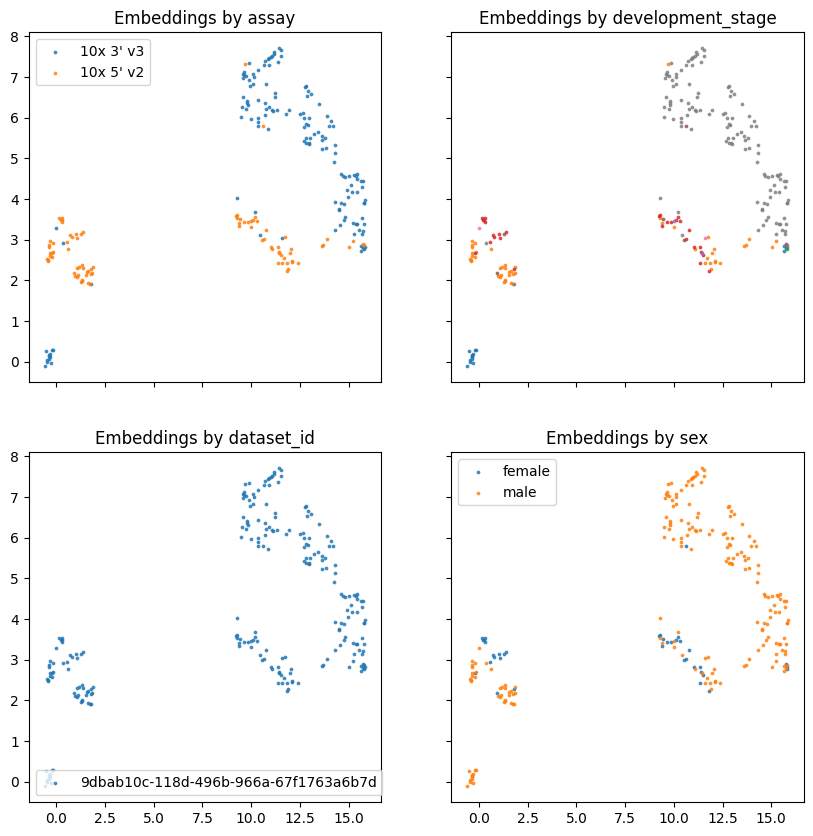

In [18]:
from matplotlib import pyplot as plt


results = adata_test.obs.copy()
results["x"] = embedding[:, 0]
results["y"] = embedding[:, 1]

covariates = ["assay", "development_stage", "dataset_id", "sex"]
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 10))

for ax, covar in zip(axes.flat, covariates):
    for cov, cov_df in results.groupby(covar):
        ax.scatter(
            cov_df.x,
            cov_df.y,
            s=3,
            alpha=0.75,
            label=cov,
        )
    if len(results[covar].unique()) < 8:
        ax.legend()
    ax.set_title(f"Embeddings by {covar}")

In [19]:
adata_test.obs.columns

Index(['soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id',
       'cell_type', 'cell_type_ontology_term_id', 'development_stage',
       'development_stage_ontology_term_id', 'disease',
       'disease_ontology_term_id', 'donor_id', 'is_primary_data',
       'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id',
       'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue',
       'tissue_ontology_term_id', 'tissue_general',
       'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz',
       'raw_variance_nnz', 'n_measured_vars'],
      dtype='object')